In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torchvision import datasets
from torch.autograd import Variable
from torchmetrics import Accuracy
from torch import cuda
import copy
%matplotlib inline

In [2]:
train_dir='C:/Datasets/Alzheimer_s Dataset/train/'
test_dir='C:/Datasets/Alzheimer_s Dataset/test/'

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader

In [4]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])

In [5]:
train_data=datasets.ImageFolder(train_dir,transform=transform)
test_data=datasets.ImageFolder(test_dir,transform=transform)

In [6]:
trainLoader=DataLoader(train_data,batch_size=50,shuffle=True)
testLoader=DataLoader(test_data,batch_size=50,shuffle=True)


In [7]:
images,labels=next(iter(trainLoader))
test_images,test_labels=next(iter(testLoader))

In [8]:
images.shape

torch.Size([50, 3, 208, 176])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x1ad12d2e850>, tensor(3))

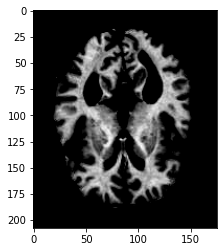

In [9]:
ID=7
plt.imshow(images[ID].permute(1,2,0)),labels[ID]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(<matplotlib.image.AxesImage at 0x1ad12df36d0>, tensor(3))

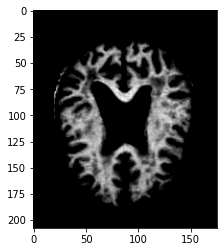

In [10]:
plt.imshow(test_images[ID].permute(1,2,0)),test_labels[ID]

In [11]:
train_data

Dataset ImageFolder
    Number of datapoints: 5121
    Root location: C:/Datasets/Alzheimer_s Dataset/train/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [12]:
test_data

Dataset ImageFolder
    Number of datapoints: 1279
    Root location: C:/Datasets/Alzheimer_s Dataset/test/
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [13]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import Sequential

In [14]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=nn.Sequential(
            nn.Conv2d(3,3,4,padding='same'),
            nn.MaxPool2d(2, 2)
        )
        self.fc1=nn.Linear(6864,120)
        self.fc2=nn.Linear(120,84)
        self.fc3=nn.Linear(84,4)
        self.softmax=nn.Softmax(dim=1)
        
    def forward(self,x):
        x=self.conv1(x)
        x=self.conv1(x)
        x=torch.flatten(x,1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.softmax(self.fc3(x))
        return x
cnn=CNN()  
if torch.cuda.is_available(): 
    cnn.cuda()


In [15]:
import os

In [16]:
os.path.exists("Model.pth")


True

In [17]:
if(os.path.exists("Model.pth")):
    metadata=torch.load("Model.pth")
    cnn.load_state_dict(metadata['model_state_dict'])


In [18]:
cnn

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 3, kernel_size=(4, 4), stride=(1, 1), padding=same)
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=6864, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)

In [19]:
def mean(arr):
    return sum(arr)/len(arr)

def getAccuracy(images,labels):
    accuracy=[]
    for i in range(len(images)):
        if torch.argmax(images[i]).item()==labels[i].item():
            accuracy.append(1)
        else:
            accuracy.append(0)
    return sum(accuracy)/len(accuracy)

def getWeightsForCrossEntropy(data):
    '''
    Return a list of wights corresponding to each class present in training data.
    Args:
    
    data (torch.utils.data.Dataset): Dataset object from which classes can be derived
    '''
    classes,counts=torch.tensor(data.targets).unique(return_counts=True)
    maxClassSize=counts.min().item()
    weights=[maxClassSize/counts[i].item() for i in range(len(counts))]
    return torch.tensor(weights)

def test(dataLoader,model,criterion):
    metrics={
        'val_loss':[],
        'val_accuracy':[]
    }
    with torch.no_grad():
        model.eval()
        for epoch in range(1):
            epoch_loss=0
            count=0
            for idx, data in enumerate(dataLoader):
                inputs,labels=data
                if torch.cuda.is_available():
                    inputs=Variable(inputs.cuda())
                    labels=Variable(labels.cuda())
                outputs=model(inputs.float())
                loss=criterion(outputs,labels)
                metrics['val_loss'].append(loss.item())
                metrics['val_accuracy'].append(getAccuracy(outputs,labels))
            print(f"Val Loss:{mean(metrics['val_loss'])}",end=" ")
            print(f"Val Accuracy:{100*mean(metrics['val_accuracy'])}\n")
    return metrics


In [20]:
def train(trainLoader,testLoader, model, optimizer, criterion):
    metrics = {
        'Accuracy': [],
        'Loss': []
    }
    acc = Accuracy()
    for epoch in range(15):
        for images, labels in trainLoader:
            if torch.cuda.is_available():
                images = Variable(images.cuda())
                labels = Variable(labels.cuda())
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            metrics['Loss'].append(loss.item())
            accuracy = getAccuracy(outputs, labels)
            metrics['Accuracy'].append(accuracy)
        print("Epoch",epoch)
        print('Accuracy/Epoch:', 100 *
              sum(metrics['Accuracy'])/len(metrics['Accuracy']),end=" ")
        print('Loss/Epoch:', sum(metrics['Loss'])/len(metrics['Loss']))
        test(testLoader, model, criterion)
    torch.save({
        'model_state_dict': cnn.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': sum(metrics['Loss'])/len(metrics['Loss']),
    }, "Model.pth")
    
    return metrics


In [21]:
criterion=nn.CrossEntropyLoss(getWeightsForCrossEntropy(train_data).cuda())
metrics=train(trainLoader,testLoader,cnn,torch.optim.Adam(cnn.parameters()),criterion)

C:\Users\Ashwin\miniconda3\lib\site-packages\torch\nn\modules\conv.py:439: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ..\aten\src\ATen\native\Convolution.cpp:660.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 0
Accuracy/Epoch: 94.14794267221448 Loss/Epoch: 0.7833975107924452
Val Loss:1.2658757659105153 Val Accuracy:57.3103448275862

Epoch 1
Accuracy/Epoch: 94.80443828016641 Loss/Epoch: 0.7790142112565273
Val Loss:1.2607887570674603 Val Accuracy:57.30503978779841

Epoch 2
Accuracy/Epoch: 95.37771613499767 Loss/Epoch: 0.7749680531449302
Val Loss:1.234587779411903 Val Accuracy:60.50663129973473

Epoch 3
Accuracy/Epoch: 95.56541840036986 Loss/Epoch: 0.7739412159595674
Val Loss:1.2664335324214056 Val Accuracy:60.37400530503978

Epoch 4
Accuracy/Epoch: 95.714470642626 Loss/Epoch: 0.7726923271290307
Val Loss:1.2511662978392382 Val Accuracy:59.56233421750663

Epoch 5
Accuracy/Epoch: 95.98089073817256 Loss/Epoch: 0.7709757186062514
Val Loss:1.2209973839613109 Val Accuracy:60.21220159151195

Epoch 6
Accuracy/Epoch: 96.05019483521616 Loss/Epoch: 0.7704021720714278
Val Loss:1.264796963104835 Val Accuracy:59.61803713527852

Epoch 7
Accuracy/Epoch: 96.20654184003766 Loss/Epoch: 0.7698557044117196
V

In [22]:
val_metrics=test(testLoader,cnn,criterion)

Val Loss:1.2823815850111155 Val Accuracy:58.24137931034483



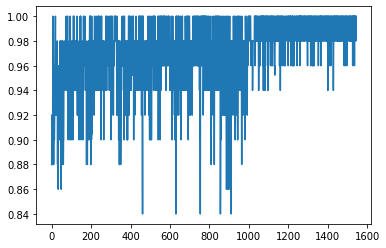

In [23]:
plt.plot(metrics['Accuracy'])

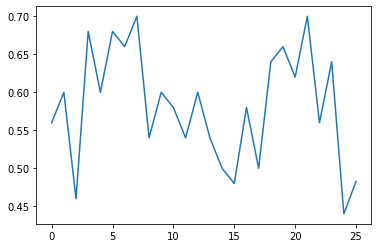

In [24]:
plt.plot(val_metrics['val_accuracy'])

C:\Users\Ashwin\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

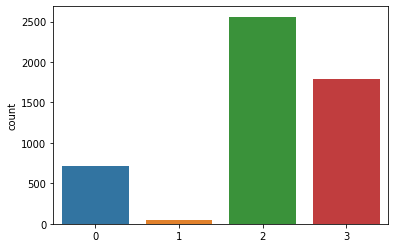

In [25]:
sns.countplot(train_data.targets)

C:\Users\Ashwin\miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

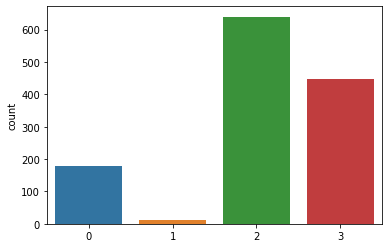

In [26]:
sns.countplot(test_data.targets)


In [27]:
getWeightsForCrossEntropy(test_data)

tensor([0.0670, 1.0000, 0.0188, 0.0268])